In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextGenerationPipeline, AdamW
import torch
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english", model_max_length=64)
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

# Try only updating final layers
params_to_update = []
for name,param in model.named_parameters():
    if 'classifier' in name:
        params_to_update.append(param)
        
optim = AdamW(params_to_update, lr=5e-5)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [3]:
sequence_0 = "I like you. I love you."

In [4]:
tokenizer.encode(sequence_0, return_tensors="pt")

tensor([[ 101, 1045, 2066, 2017, 1012, 1045, 2293, 2017, 1012,  102]])

In [5]:
model(tokenizer.encode(sequence_0, return_tensors="pt").to(device), 
      labels=torch.tensor([1]).unsqueeze(0).to(device))

SequenceClassifierOutput(loss=tensor(0.0001, device='cuda:0', grad_fn=<NllLossBackward>), logits=tensor([[-4.3136,  4.6843]], device='cuda:0', grad_fn=<AddmmBackward>), hidden_states=None, attentions=None)

In [6]:
# model(tokenizer.encode(sequence_0, return_tensors="pt"), output_attentions=True).attentions[0].sum(axis=1)

In [7]:
# S = torch.nn.Softmax(dim=1)
# S(model(tokenizer.encode(sequence_0, return_tensors="pt")).logits.detach())

In [8]:
# model

In [24]:
def train_single(input_tensor_batch, target_tensor_batch, model, model_optimizer):
    '''
    A single forward and backward pass of the neural net on a single training batch.
    '''
    target_tensor = torch.stack(target_tensor_batch).reshape(len(input_tensor_batch))
    input_tensor = torch.stack(input_tensor_batch)
    input_tensor = input_tensor.reshape(len(input_tensor_batch), input_tensor.shape[2])
    output = model(input_tensor.to(device), 
                   labels = target_tensor.to(device),
                   output_attentions=False)
    loss = output[0]
    loss.backward()
    model_optimizer.step()
    return loss.item()

def train(input_tensors, target_tensors, input_val_tensors, target_val_tensors,
          model, model_optimizer, n_epochs):
    '''
    Train the attention classfier for a given number of epochs on the whole training set.
    '''
    losses = []
    train_accs = []
    val_accs = []
    # Iterate over given num of epochs
    for epoch in range(n_epochs):
        loss = 0
        # Iterate over batches
        for i in range(len(input_tensors)):
            input_tensor = input_tensors[i]
            target_tensor = target_tensors[i]
            loss += train_single(input_tensor, target_tensor, model, 
                                 model_optimizer)
        train_accuracy = get_accuracy(input_tensors, target_tensors, model)
        val_accuracy = get_accuracy(input_val_tensors, target_val_tensors, model)
        print(f"Epoch {epoch} :") 
        print(f"\tLoss {loss/len(input_tensors):.4f}")
        print(f"\tTraining Accuracy {train_accuracy:.4f}")
        print(f"\tValidation Accuracy {val_accuracy:.4f}")
        losses.append(loss/len(input_tensors))
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)
    return losses, train_accs, val_accs

def get_accuracy(input_tensors, target_tensors, model):
    '''
    Get model accuracy.
    '''
    accs = []
    # Iterate over batches
    for i in range(len(input_tensors)):
        input_tensor_batch = input_tensors[i]
        target_tensor_batch = target_tensors[i]
        target_tensor = torch.stack(target_tensor_batch).reshape(len(input_tensor_batch)).to(device)
        input_tensor = torch.stack(input_tensor_batch)
        input_tensor = input_tensor.reshape(len(input_tensor_batch), input_tensor.shape[2]).to(device)
        output = model(input_tensor, output_attentions=False)
        # Get classification prediction
        preds = output.logits.argmax(axis=1)
        # Get accuracy of given batch
        batch_acc = ((preds == target_tensor).sum()/target_tensor.shape[0]).item()
        accs.append(batch_acc)
    return np.mean(accs)

def sent_pred(sent, model, tokenizer, device, batch_size):
    '''
    Runs the model on an input sentence.
    
    Arguments: 
    
      sent : str. The input sentence.
      model : the pytorch model to be used.
     
    Returns:
      pred : np array. The prediction, wich is a normalized array with a value for \
             each class, representing the predicted probability for that class
      attns : the attention matrix
    '''
    input_tensor = tokenizer.encode(test_text, return_tensors="pt").to(device)

    output = model(input_tensor, output_attentions=True)
    pred = output.logits.argmax(axis=1)
    
    softmax = torch.nn.Softmax(dim=1)
    scores = softmax(output.logits.detach())
    
    attns = output.attentions

    return pred.detach().cpu().numpy(), scores, attns

In [11]:
train_file = "../../../cross_style_transfer_internal/data/xslue/StanfordPoliteness/train.tsv"
dev_file = "../../../cross_style_transfer_internal/data/xslue/StanfordPoliteness/dev.tsv"

train_data = pd.read_csv(train_file, names=['domain', 'id', 'text', 'score'], sep='\t')
val_data = pd.read_csv(dev_file, names=['domain', 'id', 'text', 'score'], sep='\t')

In [12]:
def parse_stanford_politeness(polite_df):
    '''
    Parse stanford politeness dataframe into the format we need for classification.
    '''
    input_df = pd.DataFrame()
    input_df['text'] = polite_df['text']
    # Map scores >= 0 (polite) to label 1 and scores < 0 (impolite) to label 0.
    input_df['label'] = polite_df['score'].apply(lambda x : int(x >= 0))
    return input_df

def df_to_training_pairs(df, tokenizer, batch_size):
    input_tensors = df['text'].apply(lambda x : tokenizer.encode(x, 
                                                                 padding='max_length', 
                                                                 truncation=True, 
                                                                 return_tensors="pt"))
    target_tensors = df['label'].apply(lambda x : torch.LongTensor([x]))
    return input_tensors.values.reshape(-1, batch_size).tolist(), target_tensors.values.reshape(-1, batch_size).tolist()

In [13]:
train_df = parse_stanford_politeness(train_data)
val_df = parse_stanford_politeness(val_data)

In [14]:
batch_size = 32
input_tensors, target_tensors = df_to_training_pairs(train_df.head((len(train_df)//batch_size)*batch_size), 
                                                                   tokenizer, batch_size)
input_val_tensors, target_val_tensors = df_to_training_pairs(val_df.head((len(val_df)//batch_size)*batch_size), 
                                                                  tokenizer, batch_size)

In [15]:
train_epochs = 30
train(input_tensors, target_tensors, input_val_tensors, target_val_tensors, 
          model, optim, train_epochs)

Epoch 0 :
	Loss 0.8381
	Training Accuracy 0.5061
	Validation Accuracy 0.5156
Epoch 1 :
	Loss 0.6798
	Training Accuracy 0.5784
	Validation Accuracy 0.5801
Epoch 2 :
	Loss 0.6986
	Training Accuracy 0.6164
	Validation Accuracy 0.6055
Epoch 3 :
	Loss 0.7566
	Training Accuracy 0.5517
	Validation Accuracy 0.5488
Epoch 4 :
	Loss 0.8075
	Training Accuracy 0.5593
	Validation Accuracy 0.5664
Epoch 5 :
	Loss 0.9089
	Training Accuracy 0.5891
	Validation Accuracy 0.5996
Epoch 6 :
	Loss 0.9536
	Training Accuracy 0.6014
	Validation Accuracy 0.5977
Epoch 7 :
	Loss 1.2115
	Training Accuracy 0.5465
	Validation Accuracy 0.5508
Epoch 8 :
	Loss 0.9827
	Training Accuracy 0.5443
	Validation Accuracy 0.5547
Epoch 9 :
	Loss 0.8003
	Training Accuracy 0.5439
	Validation Accuracy 0.5605
Epoch 10 :
	Loss 0.7476
	Training Accuracy 0.5496
	Validation Accuracy 0.5605
Epoch 11 :
	Loss 0.7906
	Training Accuracy 0.5496
	Validation Accuracy 0.5605
Epoch 12 :
	Loss 0.7772
	Training Accuracy 0.5496
	Validation Accuracy 0.5

([0.8380786677846661,
  0.6798474111340262,
  0.6985791241387268,
  0.756607750406513,
  0.8075301591065023,
  0.9088780206519288,
  0.9536488002964428,
  1.2114562140656757,
  0.9827109575271606,
  0.8003244984459568,
  0.74759788956348,
  0.7905945468258548,
  0.7771737472964572,
  0.7100590499384063,
  0.6984392323277213,
  0.671402387030713,
  0.6516144102463475,
  0.6517731526068279,
  0.66119806371726,
  0.6588681320865433,
  0.6567046711971234,
  0.6472971946388096,
  0.6469113942864654,
  0.6364725225351073,
  0.6414429487346055,
  0.6367022348688794,
  0.6374683325940912,
  0.6353144452169344,
  0.6344416080550714,
  0.6291050860634098],
 [0.5060876623376623,
  0.5784293831168831,
  0.6163758116883117,
  0.5517451298701299,
  0.5592532467532467,
  0.5890827922077922,
  0.601359577922078,
  0.5464691558441559,
  0.544338474025974,
  0.5439326298701299,
  0.549614448051948,
  0.549614448051948,
  0.549614448051948,
  0.6262175324675324,
  0.6255073051948052,
  0.619622564935065,

In [25]:
sent = "Where did you learn English? How come you're taking on a third language?"

pred, scores, attns = sent_pred(sent, model, tokenizer, device, batch_size)

In [29]:
viz_attns = [attn.sum(axis=1) for attn in attns]

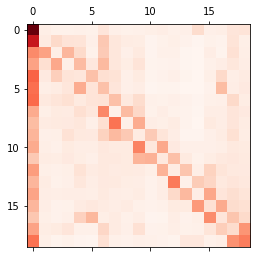

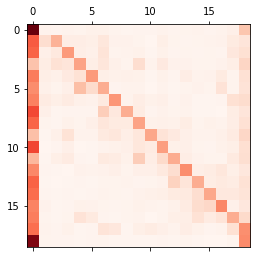

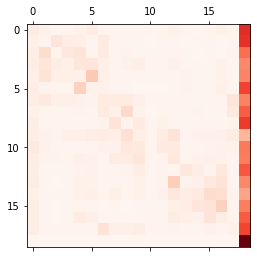

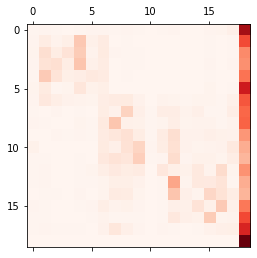

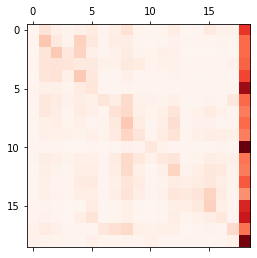

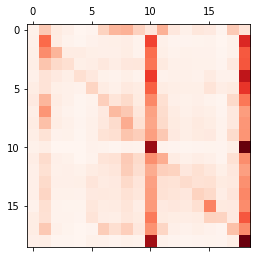

In [38]:
for attn in viz_attns:
    plt.matshow(attn[0].cpu().detach().numpy(), cmap='Reds')

In [50]:
collapsed = np.array([attn.sum(axis=1).cpu().detach().squeeze().numpy() for attn in attns]).sum(axis=0)

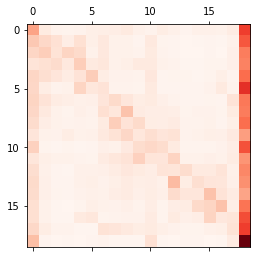

In [52]:
plt.matshow(collapsed, cmap='Reds')